#**Tutorail # 6 : Introduction to Earth System Models**


**Week 1, Day 5, Climate Modeling**

**Content creators:** Jenna Pearson, Brodie Pearson, Julius Busecke, and Abigail Bodner

**Content reviewers:** Ohad Zivan

**Content editors:** TBD

**Production editors:** TBD

**Our 2023 Sponsors:** TBD



#**Tutorial Objectives**

In this tutorial students will learn about ..

By the end of this tutorial students will be able to:
* Load data from the Community Earth System Model
* Analyze the surface energy budget of a realistic climate model

# Setup

## Package Imports

In [1]:
# note this installation takes a lonnnng time.
!pip install condacolab &> /dev/null        
import condacolab
condacolab.install()

⏬ Downloading https://github.com/jaimergp/miniforge/releases/latest/download/Mambaforge-colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:24
🔁 Restarting kernel...


In [1]:

# !conda install -c conda-forge xarray-datatree &> /dev/null
# !conda install -c conda-forge intake &> /dev/null
# !conda install -c conda-forge intake-esm &> /dev/null
# !conda install -c conda-forge gcsfs &> /dev/null
# !conda install -c conda-forge xmip &> /dev/null
# !conda install -c conda-forge aiohttp &> /dev/null
# !conda install -c conda-forge cartopy &> /dev/null
# !conda install -c conda-forge nc-time-axis &> /dev/null
# !conda install -c conda-forge cf_xarray &> /dev/null
# !conda install -c conda-forge xarrayutils &> /dev/null
# !conda install -c conda-forge xesmf &> /dev/null


# jb: trying to install all packages in one call (+ use mamba instead of conda)
# hopefully this improves speed
!mamba install xarray-datatree intake intake-esm gcsfs xmip aiohttp cartopy nc-time-axis cf_xarray xarrayutils



                  __    __    __    __
                 /  \  /  \  /  \  /  \
                /    \/    \/    \/    \
███████████████/  /██/  /██/  /██/  /████████████████████████
              /  / \   / \   / \   / \  \____
             /  /   \_/   \_/   \_/   \    o \__,
            / _/                       \_____/  `
            |/
        ███╗   ███╗ █████╗ ███╗   ███╗██████╗  █████╗
        ████╗ ████║██╔══██╗████╗ ████║██╔══██╗██╔══██╗
        ██╔████╔██║███████║██╔████╔██║██████╔╝███████║
        ██║╚██╔╝██║██╔══██║██║╚██╔╝██║██╔══██╗██╔══██║
        ██║ ╚═╝ ██║██║  ██║██║ ╚═╝ ██║██████╔╝██║  ██║
        ╚═╝     ╚═╝╚═╝  ╚═╝╚═╝     ╚═╝╚═════╝ ╚═╝  ╚═╝

        mamba (1.1.0) supported by @QuantStack

        GitHub:  https://github.com/mamba-org/mamba
        Twitter: https://twitter.com/QuantStack

█████████████████████████████████████████████████████████████


Looking for: ['xarray-datatree', 'intake', 'intake-esm', 'gcsfs', 'xmip', 'aiohttp', 'cartopy', 'nc-time-axis', '

In [2]:
import intake
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

from xmip.preprocessing import combined_preprocessing
from xarrayutils.plotting import shaded_line_plot
from xmip.utils import google_cmip_col

from datatree import DataTree
from xmip.postprocessing import _parse_metric

import cartopy.crs as ccrs

/usr/local/lib/python3.9/site-packages/pyproj/__init__.py:89: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


## Figure Settings

In [3]:
import ipywidgets as widgets       # interactive display
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/ClimateMatchAcademy/course-content/main/cma.mplstyle")

# Section 1 : The Community Earth System Model (CESM)

The complexity of our models has increased throughout this tutorial, and we end on Earth System Models (ESMs), which are the most complex of all climate models. These types of model include the physical processes typical of General Circulation Models (GCMs), but also include chemical and biological changes within the climate system (e.g. changes in vegetation, biomes, atmospheric CO2).

The [Community Earth System Model](httpshttps://www.cesm.ucar.edu/models/cesm2://) is one specific ESM we will analyze here in prepartion for next lesson when you will look at many climate models simultaneously. We will be analyzing the **historical simulation**, which covers the period 1850 to 2015 using the historicallly observed forcing of the climate system.





##**Section 1.1: Finding & opening CMIP6 data with xarray**

Massive projects like CMIP6 can contain millions of datasets. For most practical applications we only need a subset of the data. To do this, we need to specify exactly which data sets we need. The naming convections of CMIP6 data sets are standardized across all models and experiments, which allows us to load multiple related data sets with efficient code.

In order to load a CMIP6 dataset the following information must be specified:
1. ***variable_id***: The variable(s) of interest  
  * in CMIP6 SST is called *tos*
2. ***source_id***: The CMIP6 model(s) that we want data from 
3. ***table_id***: The origin system and output frequency desired of the variable(s) 
  * We use *Omon* - data from the ocean model at monthly resolution
4. ***grid_id***: The grid that we want the data to be on
  * We use *gn*  which is data on the model's *native* grid, some models also provide *gr* (*regridded* data) and other grid options
5. ***experiment_id***: The CMIP6 experiments that we want to analyze
  * We will load three experiments: *historical*, *ssp126* and *ssp585*. We'll discuss these more in the next few tutorials
6. ***member_id***: this distinguishes simulations if the same model is run repeatedly for an experiment
  * We use *r1i1p1f1* for now, but will explore this in a later tutorial

Each of these terms is called a *facet* in CMIP vocabulary.

Once you have defined the facets of interest you need to somehow search and retrieve the datasets that contain these facets. 

There are many ways to do this, but here we will show a workflow using an [intake-esm](https://intake-esm.readthedocs.io/en/stable/) catalog object based on a CSV file that is maintained by the pangeo community.




In [4]:
col = intake.open_esm_datastore("https://storage.googleapis.com/cmip6/pangeo-cmip6.json") # open an intake catalog containing the Pangeo CMIP cloud data


We just loaded the full collection of Pangeo cloud datasets into an intake catalog, and defined a list of 5 example models ('source_ids') for this demonstration

> There are many more to test out! Try running `col.df['source_id'].unique()` in a new cell to get a list of all available models

Now we will create then creates a subset according to the provided facets using the `.search()` method, and finally opens the [zarr stores]() in the cloud into xarray datasets. 

> The data returned are xarray datasets which contain [dask arrays](https://docs.dask.org/en/stable/array.html). These are 'lazy', meaning the actual data will only be loaded when a computation is performed. What is loaded here is only the metadata, which enables us to inspect e.g. the dimensionality/variable units etc without loading in GBs or TBs of data!

A subtle but important step in the opening stage is the use of a preprocessing function! By passing `preprocess=combined_preprocessing` we apply crowdsourced fixes from the [xMIP](https://github.com/jbusecke/xmip) package to each dataset. This ensures consistent naming of dimensions (and other convienient things - see [here](https://cmip6-preprocessing.readthedocs.io/en/latest/tutorial.html) for more).

In [6]:
# from the full `col` object, create a subset using facet search
cat = col.search(
    source_id='CESM2',
    variable_id=['hfls', 'hfss', 'rlds', 'rlus', 'rsds', 'rsus', 'tas', 'rsdt', 'rsut', 'rlut'],
    member_id='r1i1p1f1',
    table_id='Amon',
    grid_label='gn',
    experiment_id = ['historical','hist-nat'],
    require_all_on = ['source_id'] #make sure that we only get models which have all of the above experiments
)

# convert the sub-catalog into a datatree object, by opening each dataset into an xarray.Dataset (without loading the data)
kwargs = dict(
    preprocess=combined_preprocessing, #apply xMIP fixes to each dataset
    xarray_open_kwargs=dict(use_cftime=True), #ensure all datasets use the same time index
    storage_options={'token':'anon'} #anonymous/public authentication to google cloud storage
)

cat.esmcat.aggregation_control.groupby_attrs = ['source_id', 'experiment_id']
dt = cat.to_datatree(**kwargs)


--> The keys in the returned dictionary of datasets are constructed as follows:
	'source_id/experiment_id'


##**Section 1.2: Checking the CMIP6 datasets**

We now have a "datatree" containing the data we searched for. A datatree is a high-level container of xarray data, useful for organizing many related datasets together. You can think of a single `DataTree` object as being like a (nested) dictionary of `xarray.Dataset` objects. Each dataset in the tree is known as a "node" or "group", and we can also have empty nodes. You can explore the nodes of the tree and its contents interactively in a similar way to how you can explore the contents of an `xarray.Dataset`:

In [ ]:
dt

DataTree('None', parent=None)
└── DataTree('CESM2')
    ├── DataTree('hist-nat')
    │       Dimensions:         (member_id: 1, dcpp_init_year: 1, time: 1980, y: 192,
    │                            x: 288, nbnd: 2)
    │       Coordinates:
    │         * y               (y) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
    │         * x               (x) float64 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
    │         * time            (time) object 1850-01-15 12:00:00 ... 2014-12-15 12:00:00
    │           lon_bounds      (x, nbnd, y) float64 dask.array<chunksize=(288, 2, 192), meta=np.ndarray>
    │           lat_bounds      (y, nbnd, x) float64 dask.array<chunksize=(192, 2, 288), meta=np.ndarray>
    │           time_bounds     (time, nbnd) object dask.array<chunksize=(1980, 2), meta=np.ndarray>
    │         * nbnd            (nbnd) int64 0 1
    │           lon             (x, y) float64 360.0 360.0 360.0 360.0 ... 358.8 358.8 358.8
    │           lat             (x, y) float64 -90.0 -89.06 -88.12 ... 88.12 89.06 90.0
    │         * member_id       (member_id) object 'r1i1p1f1'
    │         * dcpp_init_year  (dcpp_init_year) float64 nan
    │       Data variables:
    │           hfls            (member_id, dcpp_init_year, time, y, x) float32 dask.array<chunksize=(1, 1, 586, 192, 288), meta=np.ndarray>
    │           hfss            (member_id, dcpp_init_year, time, y, x) float32 dask.array<chunksize=(1, 1, 577, 192, 288), meta=np.ndarray>
    │           rlds            (member_id, dcpp_init_year, time, y, x) float32 dask.array<chunksize=(1, 1, 699, 192, 288), meta=np.ndarray>
    │           rlus            (member_id, dcpp_init_year, time, y, x) float32 dask.array<chunksize=(1, 1, 716, 192, 288), meta=np.ndarray>
    │           rlut            (member_id, dcpp_init_year, time, y, x) float32 dask.array<chunksize=(1, 1, 714, 192, 288), meta=np.ndarray>
    │           rsds            (member_id, dcpp_init_year, time, y, x) float32 dask.array<chunksize=(1, 1, 672, 192, 288), meta=np.ndarray>
    │           rsdt            (member_id, dcpp_init_year, time, y, x) float32 dask.array<chunksize=(1, 1, 981, 192, 288), meta=np.ndarray>
    │           rsus            (member_id, dcpp_init_year, time, y, x) float32 dask.array<chunksize=(1, 1, 698, 192, 288), meta=np.ndarray>
    │           rsut            (member_id, dcpp_init_year, time, y, x) float32 dask.array<chunksize=(1, 1, 663, 192, 288), meta=np.ndarray>
    │           tas             (member_id, dcpp_init_year, time, y, x) float32 dask.array<chunksize=(1, 1, 813, 192, 288), meta=np.ndarray>
    │       Attributes: (12/54)
    │           Conventions:                      CF-1.7 CMIP-6.2
    │           activity_id:                      DAMIP
    │           branch_method:                    standard
    │           branch_time_in_child:             674885.0
    │           branch_time_in_parent:            306600.0
    │           case_id:                          1479
    │           ...                               ...
    │           intake_esm_attrs:member_id:       r1i1p1f1
    │           intake_esm_attrs:table_id:        Amon
    │           intake_esm_attrs:grid_label:      gn
    │           intake_esm_attrs:version:         20190730
    │           intake_esm_attrs:_data_format_:   zarr
    │           intake_esm_dataset_key:           CESM2/hist-nat
    └── DataTree('historical')
            Dimensions:         (member_id: 1, dcpp_init_year: 1, time: 1980, y: 192,
                                 x: 288, nbnd: 2)
            Coordinates:
              * y               (y) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
              * x               (x) float64 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
              * time            (time) object 1850-01-15 12:00:00 ... 2014-12-15 12:00:00
                lon_bounds      (x, nbnd, y) float64 dask.array<chunksize=(288, 2, 192), meta=np.ndarray>
                lat_bounds

Each group in the tree is stored under a corresponding `name`, and we can select nodes via their name. The real usefulness of a datatree comes from having many groups at different depths, analogous to how one might store files in nested directories (e.g. `day1/experiment1/data.txt`, `day1/experiment2/data.txt` etc.). 

In our case our particular datatree object has different CMIP models and different experiments stored at distinct levels of the tree. This is useful because we can select just one experiment for one model, or all experiments for one model, or all experiments for all models!

We can also apply xarray operations (e.g. taking the average using the `.mean()` method) over all the data in a tree at once, just by calling that same method on the `DataTree` object. We can even map custom functions over all nodes in the tree using `dt.map_over_subtree(my_function)`.

All the operations below can be accomplished without using datatrees, but it saves us many lines of code as we don't have to use `for` loops over all our the different datasets. For more information about datatree see the [documentation here](https://xarray-datatree.readthedocs.io/en/latest/index.html).

Now, let's pull out relevant CESM2 datasets from the datatree; the *historical* simulation (human & natural forcing) and the *hist-nat* simulation (natural forcing only).

In [7]:
# the historical including anthropogenic forcing
hist =  dt['CESM2']['historical']
hist

DataTree('historical', parent="CESM2")
    Dimensions:         (member_id: 1, dcpp_init_year: 1, time: 1980, y: 192,
                         x: 288, nbnd: 2)
    Coordinates:
      * y               (y) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
      * x               (x) float64 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
      * time            (time) object 1850-01-15 12:00:00 ... 2014-12-15 12:00:00
        lat_bounds      (y, nbnd, x) float64 dask.array<chunksize=(192, 2, 288), meta=np.ndarray>
        time_bounds     (time, nbnd) object dask.array<chunksize=(1980, 2), meta=np.ndarray>
        lon_bounds      (x, nbnd, y) float64 dask.array<chunksize=(288, 2, 192), meta=np.ndarray>
      * nbnd            (nbnd) int64 0 1
        lon             (x, y) float64 360.0 360.0 360.0 360.0 ... 358.8 358.8 358.8
        lat             (x, y) float64 -90.0 -89.06 -88.12 ... 88.12 89.06 90.0
      * member_id       (member_id) object 'r1i1p1f1'
      * dcpp_init_year  (dcpp_init_year) float64 nan
    Data variables:
        hfls            (member_id, dcpp_init_year, time, y, x) float32 dask.array<chunksize=(1, 1, 600, 192, 288), meta=np.ndarray>
        hfss            (member_id, dcpp_init_year, time, y, x) float32 dask.array<chunksize=(1, 1, 600, 192, 288), meta=np.ndarray>
        rlds            (member_id, dcpp_init_year, time, y, x) float32 dask.array<chunksize=(1, 1, 600, 192, 288), meta=np.ndarray>
        rlus            (member_id, dcpp_init_year, time, y, x) float32 dask.array<chunksize=(1, 1, 600, 192, 288), meta=np.ndarray>
        rlut            (member_id, dcpp_init_year, time, y, x) float32 dask.array<chunksize=(1, 1, 600, 192, 288), meta=np.ndarray>
        rsds            (member_id, dcpp_init_year, time, y, x) float32 dask.array<chunksize=(1, 1, 600, 192, 288), meta=np.ndarray>
        rsdt            (member_id, dcpp_init_year, time, y, x) float32 dask.array<chunksize=(1, 1, 600, 192, 288), meta=np.ndarray>
        rsus            (member_id, dcpp_init_year, time, y, x) float32 dask.array<chunksize=(1, 1, 600, 192, 288), meta=np.ndarray>
        rsut            (member_id, dcpp_init_year, time, y, x) float32 dask.array<chunksize=(1, 1, 600, 192, 288), meta=np.ndarray>
        tas             (member_id, dcpp_init_year, time, y, x) float32 dask.array<chunksize=(1, 1, 600, 192, 288), meta=np.ndarray>
    Attributes: (12/54)
        Conventions:                      CF-1.7 CMIP-6.2
        activity_id:                      CMIP
        branch_method:                    standard
        branch_time_in_child:             674885.0
        branch_time_in_parent:            219000.0
        case_id:                          15
        ...                               ...
        intake_esm_attrs:member_id:       r1i1p1f1
        intake_esm_attrs:table_id:        Amon
        intake_esm_attrs:grid_label:      gn
        intake_esm_attrs:version:         20190308
        intake_esm_attrs:_data_format_:   zarr
        intake_esm_dataset_key:           CESM2/historical

In [8]:
# the historical run without anthropogenic forcing
hist_nat = dt['CESM2']['hist-nat']
hist_nat

DataTree('hist-nat', parent="CESM2")
    Dimensions:         (member_id: 1, dcpp_init_year: 1, time: 1980, y: 192,
                         x: 288, nbnd: 2)
    Coordinates:
      * y               (y) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
      * x               (x) float64 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
      * time            (time) object 1850-01-15 12:00:00 ... 2014-12-15 12:00:00
        lat_bounds      (y, nbnd, x) float64 dask.array<chunksize=(192, 2, 288), meta=np.ndarray>
        time_bounds     (time, nbnd) object dask.array<chunksize=(1980, 2), meta=np.ndarray>
        lon_bounds      (x, nbnd, y) float64 dask.array<chunksize=(288, 2, 192), meta=np.ndarray>
      * nbnd            (nbnd) int64 0 1
        lon             (x, y) float64 360.0 360.0 360.0 360.0 ... 358.8 358.8 358.8
        lat             (x, y) float64 -90.0 -89.06 -88.12 ... 88.12 89.06 90.0
      * member_id       (member_id) object 'r1i1p1f1'
      * dcpp_init_year  (dcpp_init_year) float64 nan
    Data variables:
        hfls            (member_id, dcpp_init_year, time, y, x) float32 dask.array<chunksize=(1, 1, 586, 192, 288), meta=np.ndarray>
        hfss            (member_id, dcpp_init_year, time, y, x) float32 dask.array<chunksize=(1, 1, 577, 192, 288), meta=np.ndarray>
        rlds            (member_id, dcpp_init_year, time, y, x) float32 dask.array<chunksize=(1, 1, 699, 192, 288), meta=np.ndarray>
        rlus            (member_id, dcpp_init_year, time, y, x) float32 dask.array<chunksize=(1, 1, 716, 192, 288), meta=np.ndarray>
        rlut            (member_id, dcpp_init_year, time, y, x) float32 dask.array<chunksize=(1, 1, 714, 192, 288), meta=np.ndarray>
        rsds            (member_id, dcpp_init_year, time, y, x) float32 dask.array<chunksize=(1, 1, 672, 192, 288), meta=np.ndarray>
        rsdt            (member_id, dcpp_init_year, time, y, x) float32 dask.array<chunksize=(1, 1, 981, 192, 288), meta=np.ndarray>
        rsus            (member_id, dcpp_init_year, time, y, x) float32 dask.array<chunksize=(1, 1, 698, 192, 288), meta=np.ndarray>
        rsut            (member_id, dcpp_init_year, time, y, x) float32 dask.array<chunksize=(1, 1, 663, 192, 288), meta=np.ndarray>
        tas             (member_id, dcpp_init_year, time, y, x) float32 dask.array<chunksize=(1, 1, 813, 192, 288), meta=np.ndarray>
    Attributes: (12/54)
        Conventions:                      CF-1.7 CMIP-6.2
        activity_id:                      DAMIP
        branch_method:                    standard
        branch_time_in_child:             674885.0
        branch_time_in_parent:            306600.0
        case_id:                          1479
        ...                               ...
        intake_esm_attrs:member_id:       r1i1p1f1
        intake_esm_attrs:table_id:        Amon
        intake_esm_attrs:grid_label:      gn
        intake_esm_attrs:version:         20190730
        intake_esm_attrs:_data_format_:   zarr
        intake_esm_dataset_key:           CESM2/hist-nat

# Section 2 :  Surface Energy Balance


Up until this point we have been analyzing budgets at the top of the atmopshere. Now we will move to Earth's surface, where we will run into both familiar and unfamiliar terminology. 

The first two terms we will analyze define the radiative component of the surface energy budget: shortwave and longwave radiation. For each of these terms, there is an upwelling and downwelling component. This is because, for example, some of the shortwave radiation is reflected due to the surface albedo, and some longwave radiation from Earth is directed back to Earth's surface from the atmopshere. The net is given as 

\begin{align}
R_{net} = [R_{\uparrow S} - R_{\downarrow S}] + [R_{\uparrow L} - R_{\downarrow L}]
\end{align}

where the arrows indicate up(down)welling and the S and L are shortwave and longwave. Note that in keeping with the rest of the variables we will look at, the net radiation is defined with a positive value to be a flux from the ocean or land to the atmosphere. That is, positive indicates an heat transport away from the surface (upward).

We will also be looking at latent and sensible heat. **[Sensible heat](https://glossary.ametsoc.org/wiki/Sensible_heat://)** is the heat transfered due to a temperature difference between touching materials, for example between the air and the land or ocean surface. In this case, if the surface air is warmer than the land/ocean then heat is transferred from the air to the land/ocean (which is a downward or negative sensible heat flux), with an opposite-direction transfer if the air was colder than the land/ocean.

**[Latent heat](https:https://glossary.ametsoc.org/wiki/Latent_heat//)** is due to evaporation and condensation of water, as these phase changes absorb and release heat respectively. Here 'latent' means hidden, in that the energy is stored in molecules and there is no temperature change sensed through a thermometer even though a heat transfer takes place.

While these are not the only terms that comprise the surface energy budget (i.e. geothermal heating, latent heat of fusion for melting ice or snow, biological processes) these are typically the dominant terms that set the global patterns.

Let's take a look at the 'long names' of some of the variables we just downloaded.


In [ ]:
hist.hfls.long_name,hist.hfss.long_name,hist.rlds.long_name,hist.rlus.long_name,hist.rsds.long_name,hist.rsus.long_name

('Surface Upward Latent Heat Flux',
 'Surface Upward Sensible Heat Flux',
 'Surface Downwelling Longwave Radiation',
 'Surface Upwelling Longwave Radiation',
 'Surface Downwelling Shortwave Radiation',
 'Surface Upwelling Shortwave Radiation')

In [ ]:
%matplotlib inline

In [9]:
# predefine heat fluxes for each experiement, take annual means 

# model output variables (.squeeze() removes singleton dimensions)
hist_am_latent_heat_flux = hist.ds.hfls.mean(dim='time').squeeze()
hist_am_sensible_heat_flux = hist.ds.hfss.mean(dim='time').squeeze()
hist_am_downwelling_longwave_flux = hist.ds.rlds.mean(dim='time').squeeze()
hist_am_upwelling_longwave_flux = hist.ds.rlus.mean(dim='time').squeeze()
hist_am_downwelling_shortwave_flux = hist.ds.rsds.mean(dim='time').squeeze()
hist_am_upwelling_shortwave_flux = hist.ds.rsus.mean(dim='time').squeeze()

# derived ariables 
hist_am_net_shortwave_heat_flux = hist_am_upwelling_shortwave_flux - hist_am_downwelling_shortwave_flux
hist_am_net_longwave_heat_flux = hist_am_upwelling_longwave_flux - hist_am_downwelling_longwave_flux
hist_am_net_heat_flux = hist_am_net_shortwave_heat_flux + hist_am_net_longwave_heat_flux + hist_am_latent_heat_flux + hist_am_sensible_heat_flux

Now we will plot the annual mean over the historical time period 1850-2015.

In [ ]:
fig, ([ax_latent, ax_shortwave], [ax_sensible, ax_longwave]) = plt.subplots(
    ncols=2, nrows=2,
    figsize=[12,6],
    subplot_kw={'projection':ccrs.Robinson()}
)

# plot surface latent heat flux the first month of the historical period
hist_am_latent_heat_flux.plot(ax=ax_latent, x='lon', y='lat', transform=ccrs.PlateCarree(), vmin=-300, vmax=300, cmap='coolwarm', robust=True,
                  cbar_kwargs={'label': '$W/m^2$'})
ax_latent.coastlines()
ax_latent.set_title('Latent Heat Flux')

# Repeat for sensible heat flux
hist_am_sensible_heat_flux.plot(ax=ax_sensible, x='lon', y='lat', transform=ccrs.PlateCarree(), vmin=-150, vmax=150, cmap='coolwarm', robust=True,
                  cbar_kwargs={'label': '$W/m^2$'})
ax_sensible.coastlines()
ax_sensible.set_title('Sensible Heat Flux')

# Repeat for net shortwave radiative heat flux
hist_am_net_shortwave_heat_flux.plot(ax=ax_shortwave, x='lon', y='lat', transform=ccrs.PlateCarree(), vmin=-300, vmax=300, cmap='coolwarm', robust=True,
                  cbar_kwargs={'label': '$W/m^2$'})
ax_shortwave.coastlines()
ax_shortwave.set_title('Net Upward Shortwave Flux')

# Repeat for net longwave radiative heat flux 
hist_am_net_longwave_heat_flux.plot(ax=ax_longwave, x='lon', y='lat', transform=ccrs.PlateCarree(), vmin=-150, vmax=150, cmap='coolwarm', robust=True,
                  cbar_kwargs={'label': '$W/m^2$'})
ax_longwave.coastlines()
ax_longwave.set_title('Net Upward Longwave Flux')

Text(0.5, 1.0, 'Net Upward Longwave Flux')

## Questions

1. What do you think could cause the stark spatial variations of the sensible heat flux between strong positive, weak, and strong negative fluxes? Discuss ocean, land and ice in your answer.
2. Describe the zonal and meridional patterns of longwave radiation. Can you think of what atmospheric processes might be related?

# Section 3: Surface Energy Budget by Latitude

We can also calculate a *zonal average* which allows us to comapare the contributions of each of these fluxes to the net heat flux by latitude (similar to the plot in the last lecture that considered the RCE model prediction as a function of latitude).

Abbie and Brodie: Comment on how we can average (without cell area concerns) in CESM or no? Also double check that we can please.

In [ ]:
# find the zonal means (.squeeze() removes singleton dimensions)
hist_azm_latent_heat_flux = hist_am_latent_heat_flux.mean(dim='x').squeeze()
hist_azm_sensible_heat_flux = hist_am_sensible_heat_flux.mean(dim='x').squeeze()
hist_azm_net_shortwave_flux = hist_am_net_shortwave_heat_flux.mean(dim='x').squeeze()
hist_azm_net_longwave_flux = hist_am_net_longwave_heat_flux.mean(dim='x').squeeze()
hist_azm_net_heat_flux = hist_am_net_heat_flux.mean(dim='x').squeeze()

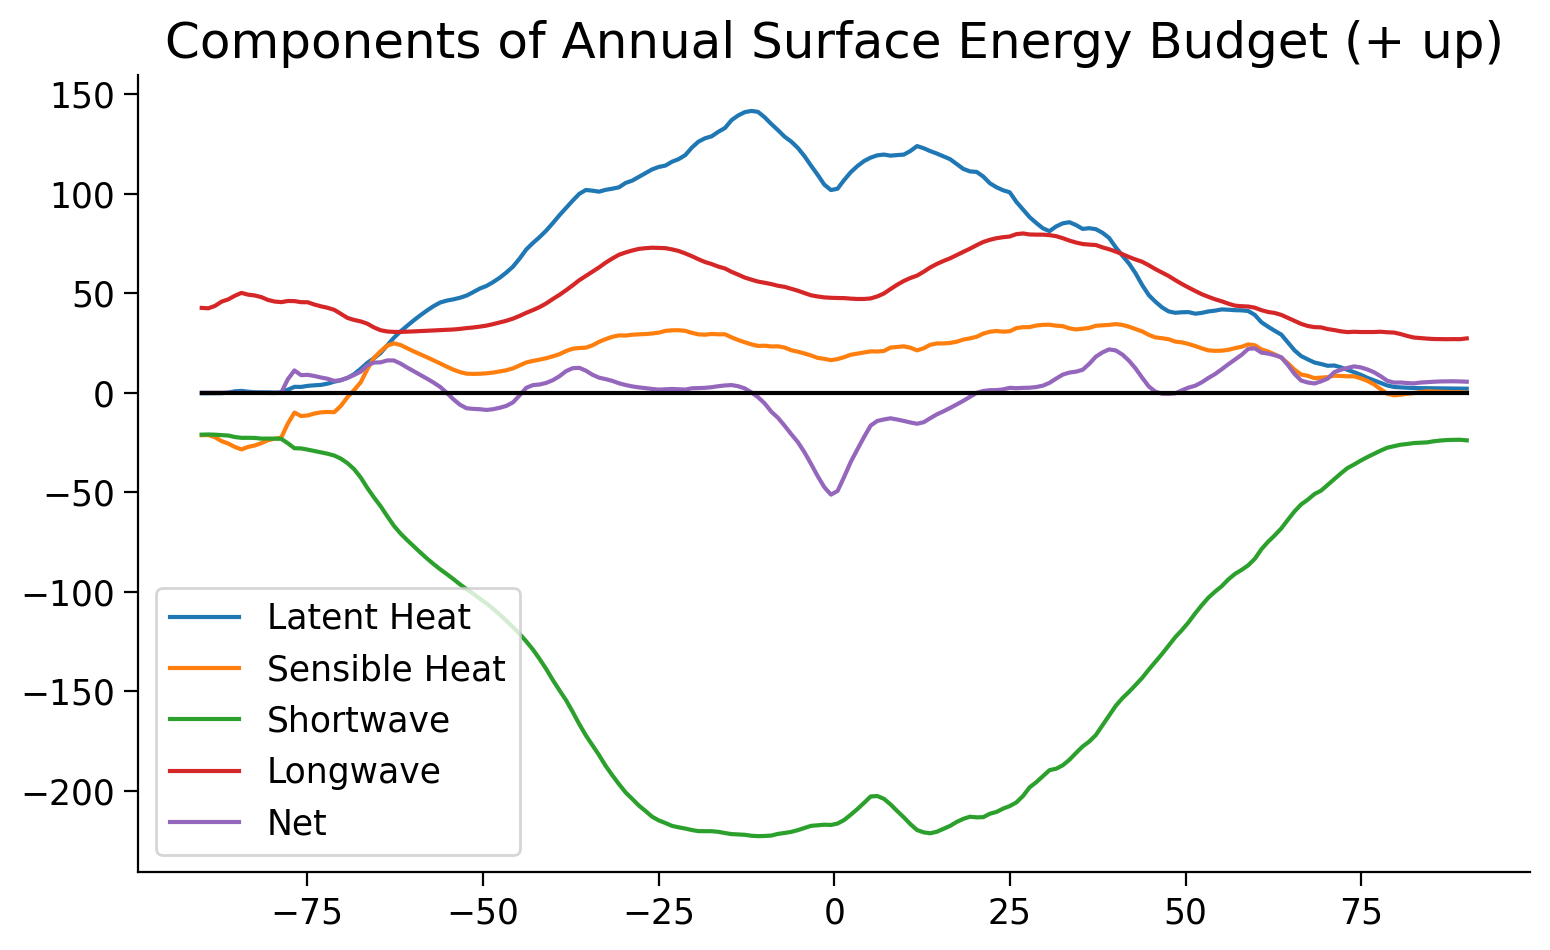

In [ ]:
lat = hist_am_latent_heat_flux.lat[0,:]

fig = plt.figure(figsize=(8,5))

plt.plot(lat, hist_azm_latent_heat_flux, label = 'Latent Heat')
plt.plot(lat, hist_azm_sensible_heat_flux, label = 'Sensible Heat')
plt.plot(lat, hist_azm_net_shortwave_flux, label = 'Shortwave')
plt.plot(lat, hist_azm_net_longwave_flux, label = 'Longwave')
plt.plot(lat, hist_azm_net_heat_flux, label = 'Net')
plt.plot(lat, 0*lat, color = 'black')

plt.title('Components of Annual Surface Energy Budget (+ up)')
plt.legend()

## Questions

1.  Describe the dominant balance in the tropics (30S to 30N)
2.  What about for the polar regions (above 60N and 60S).
3.  What do you think the dip in latent heat is around the equator?
4.  Is there symmetry in the longwave radiation in the high southern and northern latitudes? What about for sensible heat?

*BONUS QUESTION:*

5. Hypothetically, imagine this plot showed that the net heat flux was:
  - -100 $W m^{-2}$ between 45$^oN$ to 45$^oS$ (i.e., 90 degrees of latitude centered on the Equator) and,
  - +100 $W m^{-2}$ between 45$^oN$ to 90$^oN$ and also between 45$^oS$ to 90$^oS$

  Would you expect Earth to warm, cool, or remain the same temperature? Why? 
  
  *BONUS BONUS QUESTION: Can you suggest adjusted latitude ranges for these two fluxes that would create the other two Earth trajectories?*

In [ ]:
print(hist_am_latent_heat_flux.lat[:,-50:-1].sum(dim='y'))

<xarray.DataArray 'lat' (x: 288)>
array([3255.54973822, 3255.54973822, 3255.54973822, 3255.54973822,
       3255.54973822, 3255.54973822, 3255.54973822, 3255.54973822,
       3255.54973822, 3255.54973822, 3255.54973822, 3255.54973822,
       3255.54973822, 3255.54973822, 3255.54973822, 3255.54973822,
       3255.54973822, 3255.54973822, 3255.54973822, 3255.54973822,
       3255.54973822, 3255.54973822, 3255.54973822, 3255.54973822,
       3255.54973822, 3255.54973822, 3255.54973822, 3255.54973822,
       3255.54973822, 3255.54973822, 3255.54973822, 3255.54973822,
       3255.54973822, 3255.54973822, 3255.54973822, 3255.54973822,
       3255.54973822, 3255.54973822, 3255.54973822, 3255.54973822,
       3255.54973822, 3255.54973822, 3255.54973822, 3255.54973822,
       3255.54973822, 3255.54973822, 3255.54973822, 3255.54973822,
       3255.54973822, 3255.54973822, 3255.54973822, 3255.54973822,
       3255.54973822, 3255.54973822, 3255.54973822, 3255.54973822,
       3255.54973822, 3255.5

In [ ]:
print(hist_am_latent_heat_flux.lon[-50:-1,:].sum(dim='x'))

<xarray.DataArray 'lon' (y: 192)>
array([16047.5, 16047.5, 16047.5, 16047.5, 16047.5, 16047.5, 16047.5,
       16047.5, 16047.5, 16047.5, 16047.5, 16047.5, 16047.5, 16047.5,
       16047.5, 16047.5, 16047.5, 16047.5, 16047.5, 16047.5, 16047.5,
       16047.5, 16047.5, 16047.5, 16047.5, 16047.5, 16047.5, 16047.5,
       16047.5, 16047.5, 16047.5, 16047.5, 16047.5, 16047.5, 16047.5,
       16047.5, 16047.5, 16047.5, 16047.5, 16047.5, 16047.5, 16047.5,
       16047.5, 16047.5, 16047.5, 16047.5, 16047.5, 16047.5, 16047.5,
       16047.5, 16047.5, 16047.5, 16047.5, 16047.5, 16047.5, 16047.5,
       16047.5, 16047.5, 16047.5, 16047.5, 16047.5, 16047.5, 16047.5,
       16047.5, 16047.5, 16047.5, 16047.5, 16047.5, 16047.5, 16047.5,
       16047.5, 16047.5, 16047.5, 16047.5, 16047.5, 16047.5, 16047.5,
       16047.5, 16047.5, 16047.5, 16047.5, 16047.5, 16047.5, 16047.5,
       16047.5, 16047.5, 16047.5, 16047.5, 16047.5, 16047.5, 16047.5,
       16047.5, 16047.5, 16047.5, 16047.5, 16047.5, 1604